In [2]:
%cd ..
%load_ext autoreload
%autoreload 2


/home/teo/userdata/SejongMusic


In [13]:
import argparse
import datetime
import copy
from pathlib import Path
from omegaconf import OmegaConf
from fractions import Fraction
from tqdm.auto import tqdm

import torch
from music21 import converter, stream, note as m21_note 
import numpy as np

from sejong_music import model_zoo, jg_code, inference
from sejong_music.yeominrak_processing import OrchestraScoreSeq, ShiftedAlignedScore, Tokenizer
from sejong_music.model_zoo import JeongganTransSeq2seq, JeongganBERT
from sejong_music.decode import MidiDecoder, OrchestraDecoder
from sejong_music.inference_utils import prepare_input_for_next_part, get_measure_specific_output, fix_measure_idx, fill_in_source, get_measure_shifted_output, recover_beat, round_number
from sejong_music.inference import JGInferencer
from sejong_music.jg_to_staff_converter import JGToStaffConverter
from sejong_music.jg_code import JeongganDataset, JeongganTokenizer, JGMaskedDataset, JeongganPiece
from sejong_music.full_inference import Generator

In [12]:
state_dir = Path('wandb/run-20240405_024457-mu1ytssm/files/checkpoints')
config_fn = state_dir / 'config.yaml'
json_fn = state_dir / 'tokenizer_vocab.json'
ckpt_fn = state_dir / 'inst_0' / 'iter46400_model.pt'

assert config_fn.exists() and json_fn.exists() and ckpt_fn.exists()

config = OmegaConf.load(config_fn)
tokenizer = JeongganTokenizer(None, None, True, json_fn=json_fn)
model = JeongganBERT(tokenizer=tokenizer, config=config.model)
model.load_state_dict(torch.load(ckpt_fn, map_location='cpu'))
dataset = JGMaskedDataset(is_valid=True, tokenizer=tokenizer, augment_param=config.aug)
augmentor = dataset.augmentor

Converting segments to roll...: 100%|██████████| 6/6 [00:00<00:00, 11.86it/s]


In [43]:
def convert_to_input_format(roll_array:np.ndarray):
  assert roll_array.ndim == 2
  roll_list = roll_array.tolist()
  roll_list = [ ['start'] * len(roll_list[0])] + roll_list + [ ['end'] * len(roll_list[0])]
  tokens = tokenizer(roll_list)
  return torch.LongTensor(tokens)

def aug_form_to_input_form(x:torch.Tensor):
  assert x.ndim == 3
  return x.permute(2,0,1).flatten(0,1)

x = dataset.entire_segments[0]['daegeum']
x = convert_to_input_format(x)
x, loss_mask = augmentor.mask_except_start_beat(x)
x, loss_mask = aug_form_to_input_form(x), aug_form_to_input_form(loss_mask)

In [150]:
gen_str = open('music_score/chwipunghyeong_gen.txt').read()
piece = JeongganPiece(None, gen_str=gen_str, inst_list=['piri'])

x = piece.convert_tokens_to_roll(piece.sliced_parts_by_measure[5]['piri'], 'piri')
x = convert_to_input_format(x)
x, loss_mask = augmentor.mask_except_start_beat(x)
x, loss_mask = aug_form_to_input_form(x), aug_form_to_input_form(loss_mask)

x = bert_inference(model, x, loss_mask, 3)

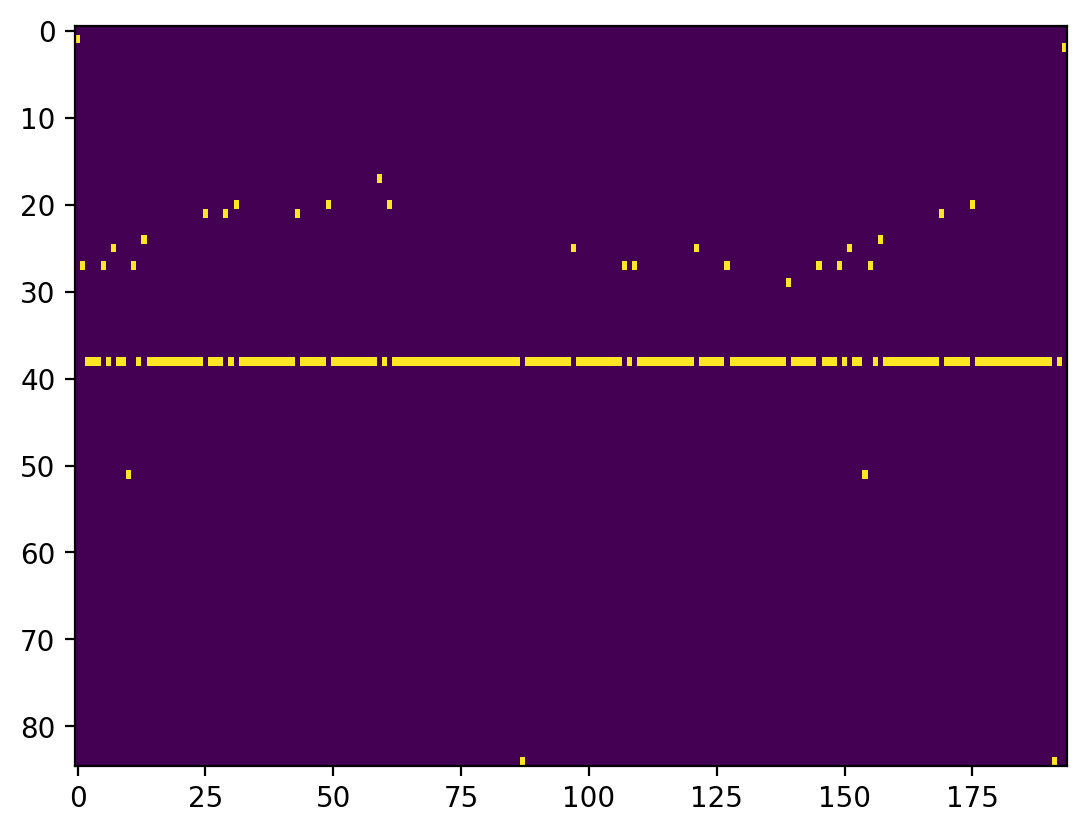

In [124]:
import matplotlib.pyplot as plt
from  torch.nn.functional import one_hot

plt.imshow(one_hot(x[:, 0]).T, aspect='auto', interpolation='nearest')

In [93]:
def bert_inference(model, x, loss_mask, n):
  with torch.inference_mode():
    pitch_mask_remaining = loss_mask[:,0].sum()
    while pitch_mask_remaining >0:
      pred, _ = model(x.unsqueeze(0))
      pred = pred[0] # (T, C)
      pitch_pred = pred[:, 0]
      pitch_mask = loss_mask[:, 0]

      is_masked = pitch_mask==1
      pitch_masked_idx = torch.where(is_masked)[0]
      
      masked_pitch_prob = pitch_pred[is_masked].softmax(dim=-1)
      high_prob_idx = masked_pitch_prob.max(dim=-1).values.argsort(descending=True)[:n]
      high_prob_pitches = masked_pitch_prob[high_prob_idx].argmax(dim=-1)
      
      selected_idx = pitch_masked_idx[high_prob_idx]
      x[selected_idx, 0] = high_prob_pitches 
      loss_mask[selected_idx, 0] = 0
      pitch_mask_remaining = loss_mask[:,0].sum()
    
    orn_mask_remaining = loss_mask[:,1].sum()  
    while orn_mask_remaining >0:
      pred, _ = model(x.unsqueeze(0))
      pred = pred[0] # (T, C)
      orn_pred = pred[:, 1]
      orn_mask = loss_mask[:, 1]

      is_masked = orn_mask==1
      orn_masked_idx = torch.where(is_masked)[0]
      
      masked_orn_prob = orn_pred[is_masked].softmax(dim=-1)
      high_prob_idx = masked_orn_prob.max(dim=-1).values.argsort(descending=True)[:n]
      high_prob_orns = masked_orn_prob[high_prob_idx].argmax(dim=-1)
      
      selected_idx = orn_masked_idx[high_prob_idx]
      x[selected_idx, 1] = high_prob_orns 
      loss_mask[selected_idx, 1] = 0
      orn_mask_remaining = loss_mask[:,1].sum()
  return x

In [58]:
n = 3
pitch_mask_remaining = loss_mask[:,0].sum()
while pitch_mask_remaining >0:
  pred, _ = model(x.unsqueeze(0))
  pred = pred[0] # (T, C)
  pitch_pred = pred[:, 0]
  pitch_mask = loss_mask[:, 0]

  is_masked = pitch_mask==1
  pitch_masked_idx = torch.where(is_masked)[0]
  
  masked_pitch_prob = pitch_pred[is_masked].softmax(dim=-1).detach()
  high_prob_idx = masked_pitch_prob.max(dim=-1).values.argsort(descending=True)[:n]
  high_prob_pitches = masked_pitch_prob[high_prob_idx].argmax(dim=-1)
  
  selected_idx = pitch_masked_idx[high_prob_idx]
  x[selected_idx, 0] = high_prob_pitches 
  loss_mask[selected_idx, 0] = 0
  pitch_mask_remaining = loss_mask[:,0].sum()

orn_mask_remaining = loss_mask[:,1].sum()  
while orn_mask_remaining >0:
  pred, _ = model(x.unsqueeze(0))
  pred = pred[0] # (T, C)
  orn_pred = pred[:, 1]
  orn_mask = loss_mask[:, 1]

  is_masked = orn_mask==1
  orn_masked_idx = torch.where(is_masked)[0]
  
  masked_orn_prob = orn_pred[is_masked].softmax(dim=-1).detach()
  high_prob_idx = masked_orn_prob.max(dim=-1).values.argsort(descending=True)[:n]
  high_prob_orns = masked_orn_prob[high_prob_idx].argmax(dim=-1)
  
  selected_idx = orn_masked_idx[high_prob_idx]
  x[selected_idx, 1] = high_prob_orns 
  loss_mask[selected_idx, 1] = 0
  orn_mask_remaining = loss_mask[:,1].sum()

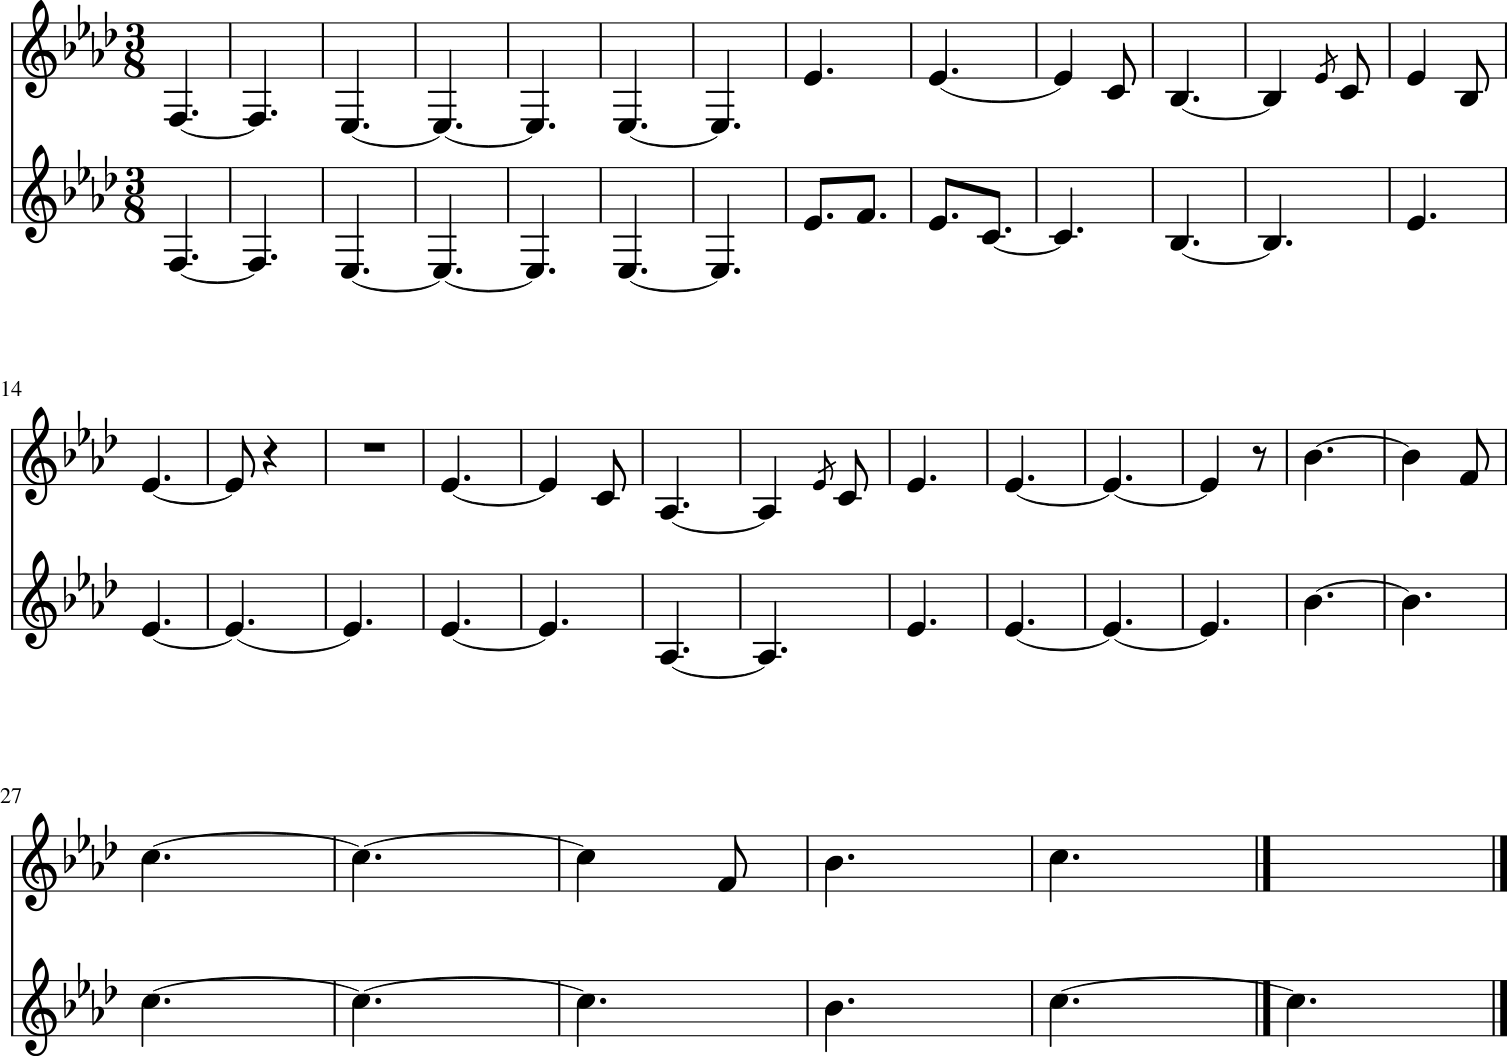

In [151]:
import music21
import copy
from typing import List
from sejong_music.jeonggan_utils import JGConverter, GencodeConverter, RollToJGConverter
from sejong_music.jg_to_staff_converter import JGToStaffConverter


roll = tokenizer.decode(x)

converter = RollToJGConverter()
jg_omr_str = converter(roll)
gen_str = GencodeConverter.convert_lines_to_gencode(jg_omr_str.split('\n'))
staff_converter = JGToStaffConverter()
mnotes, score = staff_converter(gen_str)

org_token = piece.sliced_parts_by_measure[5]['piri']
org_nots, org_score = staff_converter(org_token)

total_score = music21.stream.Score()
total_score.insert(0, score)
total_score.insert(0, org_score)
total_score.show()

In [146]:
gen_str

':2 남 :8 남 | :2 임 :6 노 :8 남 미는표 | :0 중 |  | :2 태 :8 태 | :0 황 |  | :0 태 \n :0 황 | :8 배남 | :0 황 |  |  |  | :5 쉼표 \n :0 임 | :8 남 | :0 남 |  | :0 임 | :0 남 |  | :0 청황 \n :2 남 :8 남 서침표 | :2 임 :6 노 :8 남 미는표 | :0 중 |  | :0 태 | :0 황 |  | :7 쉼표'

In [148]:
jg_omr_str

'남:2 -:5 남:8|임:2 -:4 노:6 남_미는표:8|중:5|-:5|태:2 -:5 태:8|황:5|-:5|태:5\n황:5|-:2 -:5 배남:8|황:5|-:5|-:5|-:5|-:2 쉼표:5 -:8\n임:5|-:2 -:5 남:8|남:5|-:5|임:5|남:5|-:5|청황:5\n남:2 -:5 남_서침표:8|임:2 -:4 노:6 남_미는표:8|중:5|-:5|태:5|황:5|-:5|-:2 -:5 쉼표:7'

In [147]:
roll

[['start', 'start', 'start', 'start', 'start', 'start'],
 ['남', '비어있음', 'beat:0', 'jg:0', 'gak:0', 'piri', 'dur:4'],
 ['-', '비어있음', 'beat:1', 'jg:0', 'gak:0', 'piri'],
 ['-', '비어있음', 'beat:2', 'jg:0', 'gak:0', 'piri'],
 ['-', '비어있음', 'beat:3', 'jg:0', 'gak:0', 'piri'],
 ['남', '비어있음', 'beat:4', 'jg:0', 'gak:0', 'piri', 'dur:2'],
 ['-', '비어있음', 'beat:5', 'jg:0', 'gak:0', 'piri'],
 ['임', '비어있음', 'beat:0', 'jg:1', 'gak:0', 'piri', 'dur:3'],
 ['-', '비어있음', 'beat:1', 'jg:1', 'gak:0', 'piri'],
 ['-', '비어있음', 'beat:2', 'jg:1', 'gak:0', 'piri'],
 ['노', '비어있음', 'beat:3', 'jg:1', 'gak:0', 'piri', 'dur:1'],
 ['남', '미는표', 'beat:4', 'jg:1', 'gak:0', 'piri', 'dur:2'],
 ['-', '비어있음', 'beat:5', 'jg:1', 'gak:0', 'piri'],
 ['중', '비어있음', 'beat:0', 'jg:2', 'gak:0', 'piri', 'dur:12'],
 ['-', '비어있음', 'beat:1', 'jg:2', 'gak:0', 'piri'],
 ['-', '비어있음', 'beat:2', 'jg:2', 'gak:0', 'piri'],
 ['-', '비어있음', 'beat:3', 'jg:2', 'gak:0', 'piri'],
 ['-', '비어있음', 'beat:4', 'jg:2', 'gak:0', 'piri'],
 ['-', '비어있음', 'beat:5

In [161]:
from sejong_music.jg_code import JeongganPiece

JeongganPiece('music_score/chwipunghyeong.txt')

UnboundLocalError: local variable 'cutted_part' referenced before assignment

In [24]:
with open('music_score/chwipunghyeong.txt') as f:
  jg_omr_str = f.read()
# jg_omr_str.split('\n')
gen_str =GencodeConverter.convert_lines_to_gencode(jg_omr_str.split('\n'))
gen_str

':0 대 |  | :0 협 |  |  | :0 대 |  |  \n  |  | :0 대 |  |  |  |  |  \n :0 대 |  | :0 협 | :10 대 :11 배무 |  | :0 배이 |  | :0 배무 \n :0 배이 |  | :0 대 |  | :0 배무 | :0 배이 | :0 대 |  \n :0 협 | :0 대 | :0 배무 |  | :0 배이 | :0 배유 |  |  \n :0 배협 |  | :0 배대 |  |  | :0 배대 |  | :10 대 :11 협 \n :10 대 :11 배무 |  | :0 배이 |  | :0 대 | :0 대 |  |  \n :0 대 |  | :0 배유 |  | :0 대 | :0 대 |  |  \n :0 이 |  | :0 무 |  |  | :0 이 | :0 무 |  \n :0 이 |  | :0 이 |  |  |  |  |  \n :0 무 |  | :0 청대 |  |  | :0 무 |  |  \n :0 이 |  | :0 유 |  |  | :0 이 |  | :0 청대 \n :0 무 | :0 이 | :0 유 |  | :0 협 | :0 대 |  | :0 협 \n :0 대 |  | :0 대 |  |  |  |  |  \n :0 이 |  | :0 무 |  | :0 이 | :0 무 |  | :0 청대 \n :0 무 | :0 이 | :0 유 |  | :0 협 | :0 대 |  |  \n :0 이 |  | :0 유 | :10 협 :11 대 |  | :0 협 | :0 유 |  \n :0 이 |  | :0 무 |  |  | :0 이 | :0 청대 |  \n  |  | :0 무 |  | :0 이 | :0 유 |  |  \n :0 협 |  | :0 대 |  |  | :0 대 |  | :0 협 \n :10 대 :11 배무 |  | :0 배이 |  | :0 대 | :0 대 |  |  \n :0 대 |  | :0 배유 |  | :0 대 | :0 대 |  |  \n :0 유 |  | :0 이 | :0 무 |  | :0 이 | :0 무 |  \n :0 

In [25]:
pitch_mapping = {'배대':'배황', '배협':'배태', '배유':'배중', '배이':'배임', '배무':'배남',
'대':'황', '협':'태', '유':'중', '이':'임', '무':'남', '청대':'청황', '청협':'청태'}

outputs = []
for token in gen_str.split(' '):
  if token in pitch_mapping:
    outputs.append(pitch_mapping[token])
  else:
    outputs.append(token)
outputs = ' '.join(outputs)

with open('music_score/chwipunghyeong_gen.txt', 'w') as f:
  f.write(outputs)

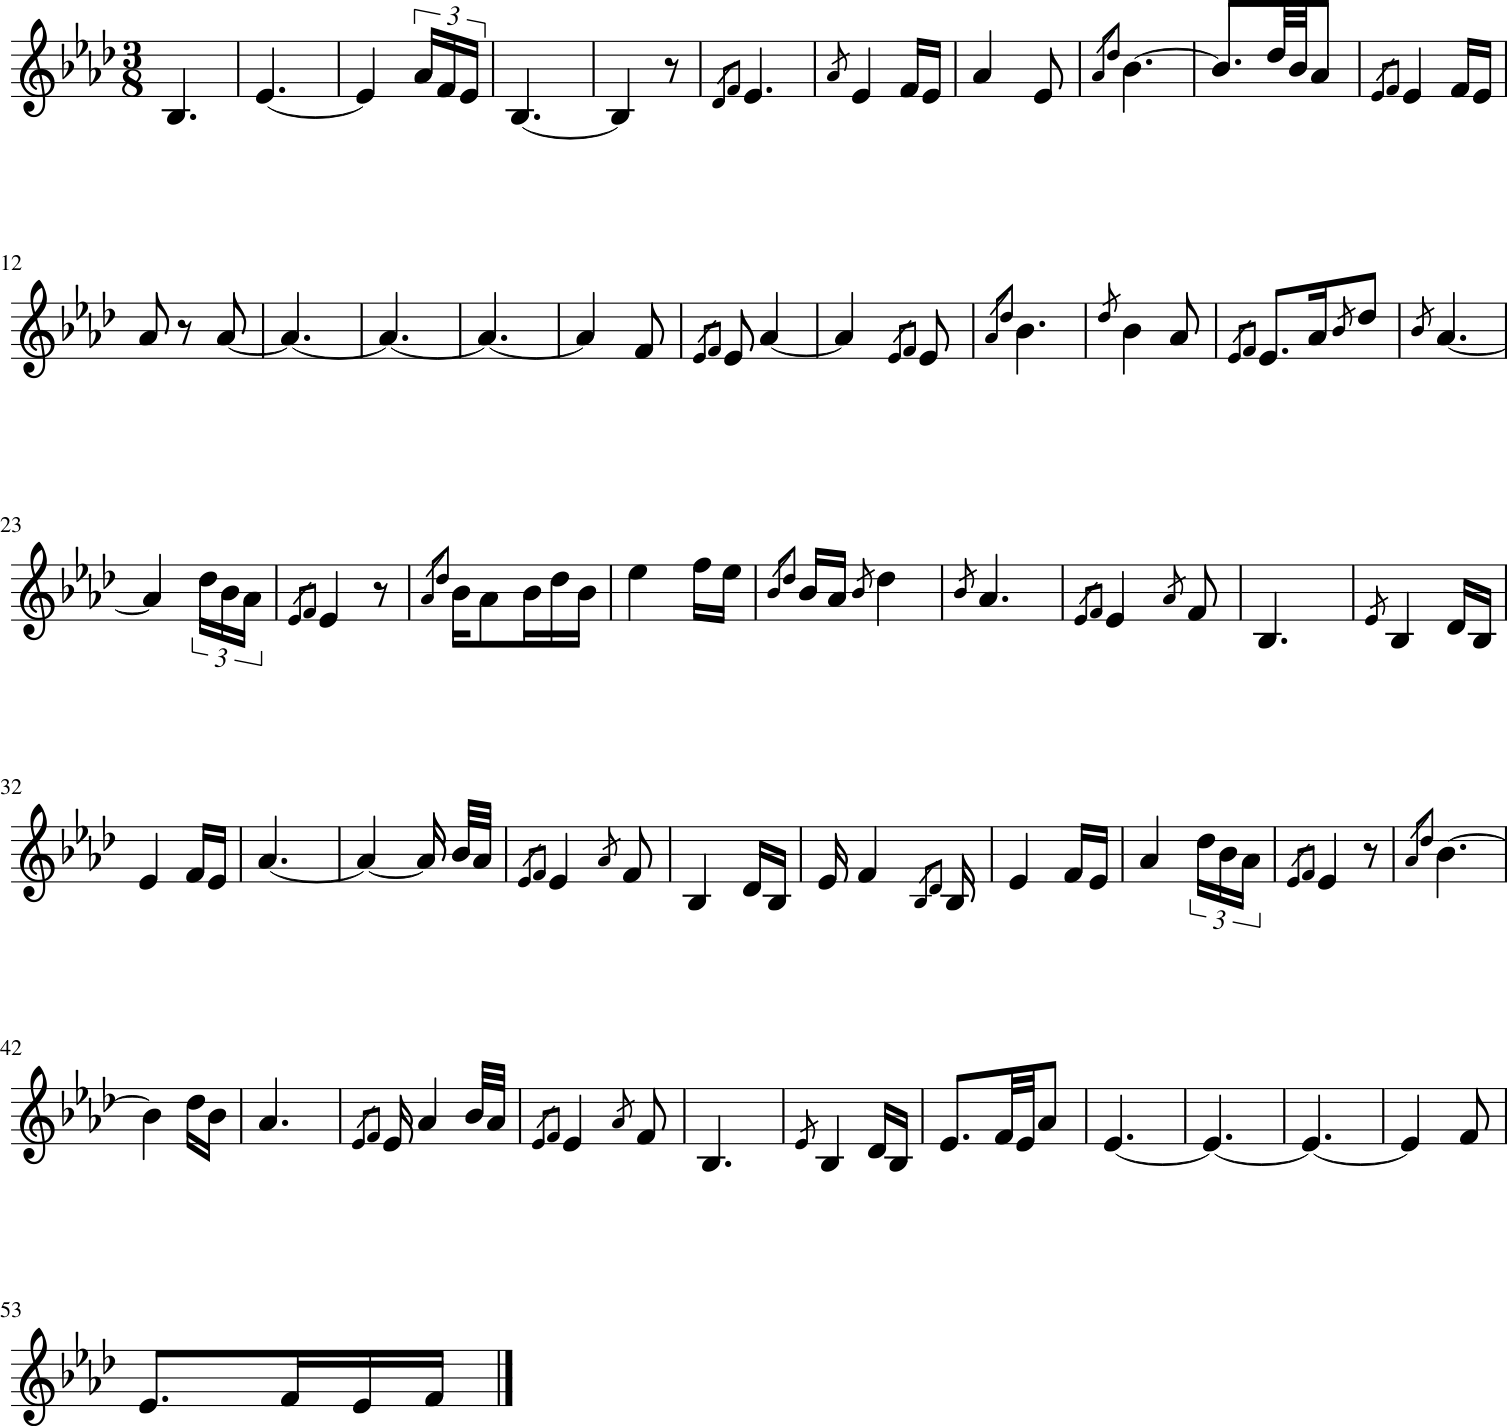

In [144]:
score.show()

In [154]:
org_token = dataset.all_pieces[0].sliced_parts_by_measure[0]['daegeum']
org_notes, org_score = staff_converter(org_token)

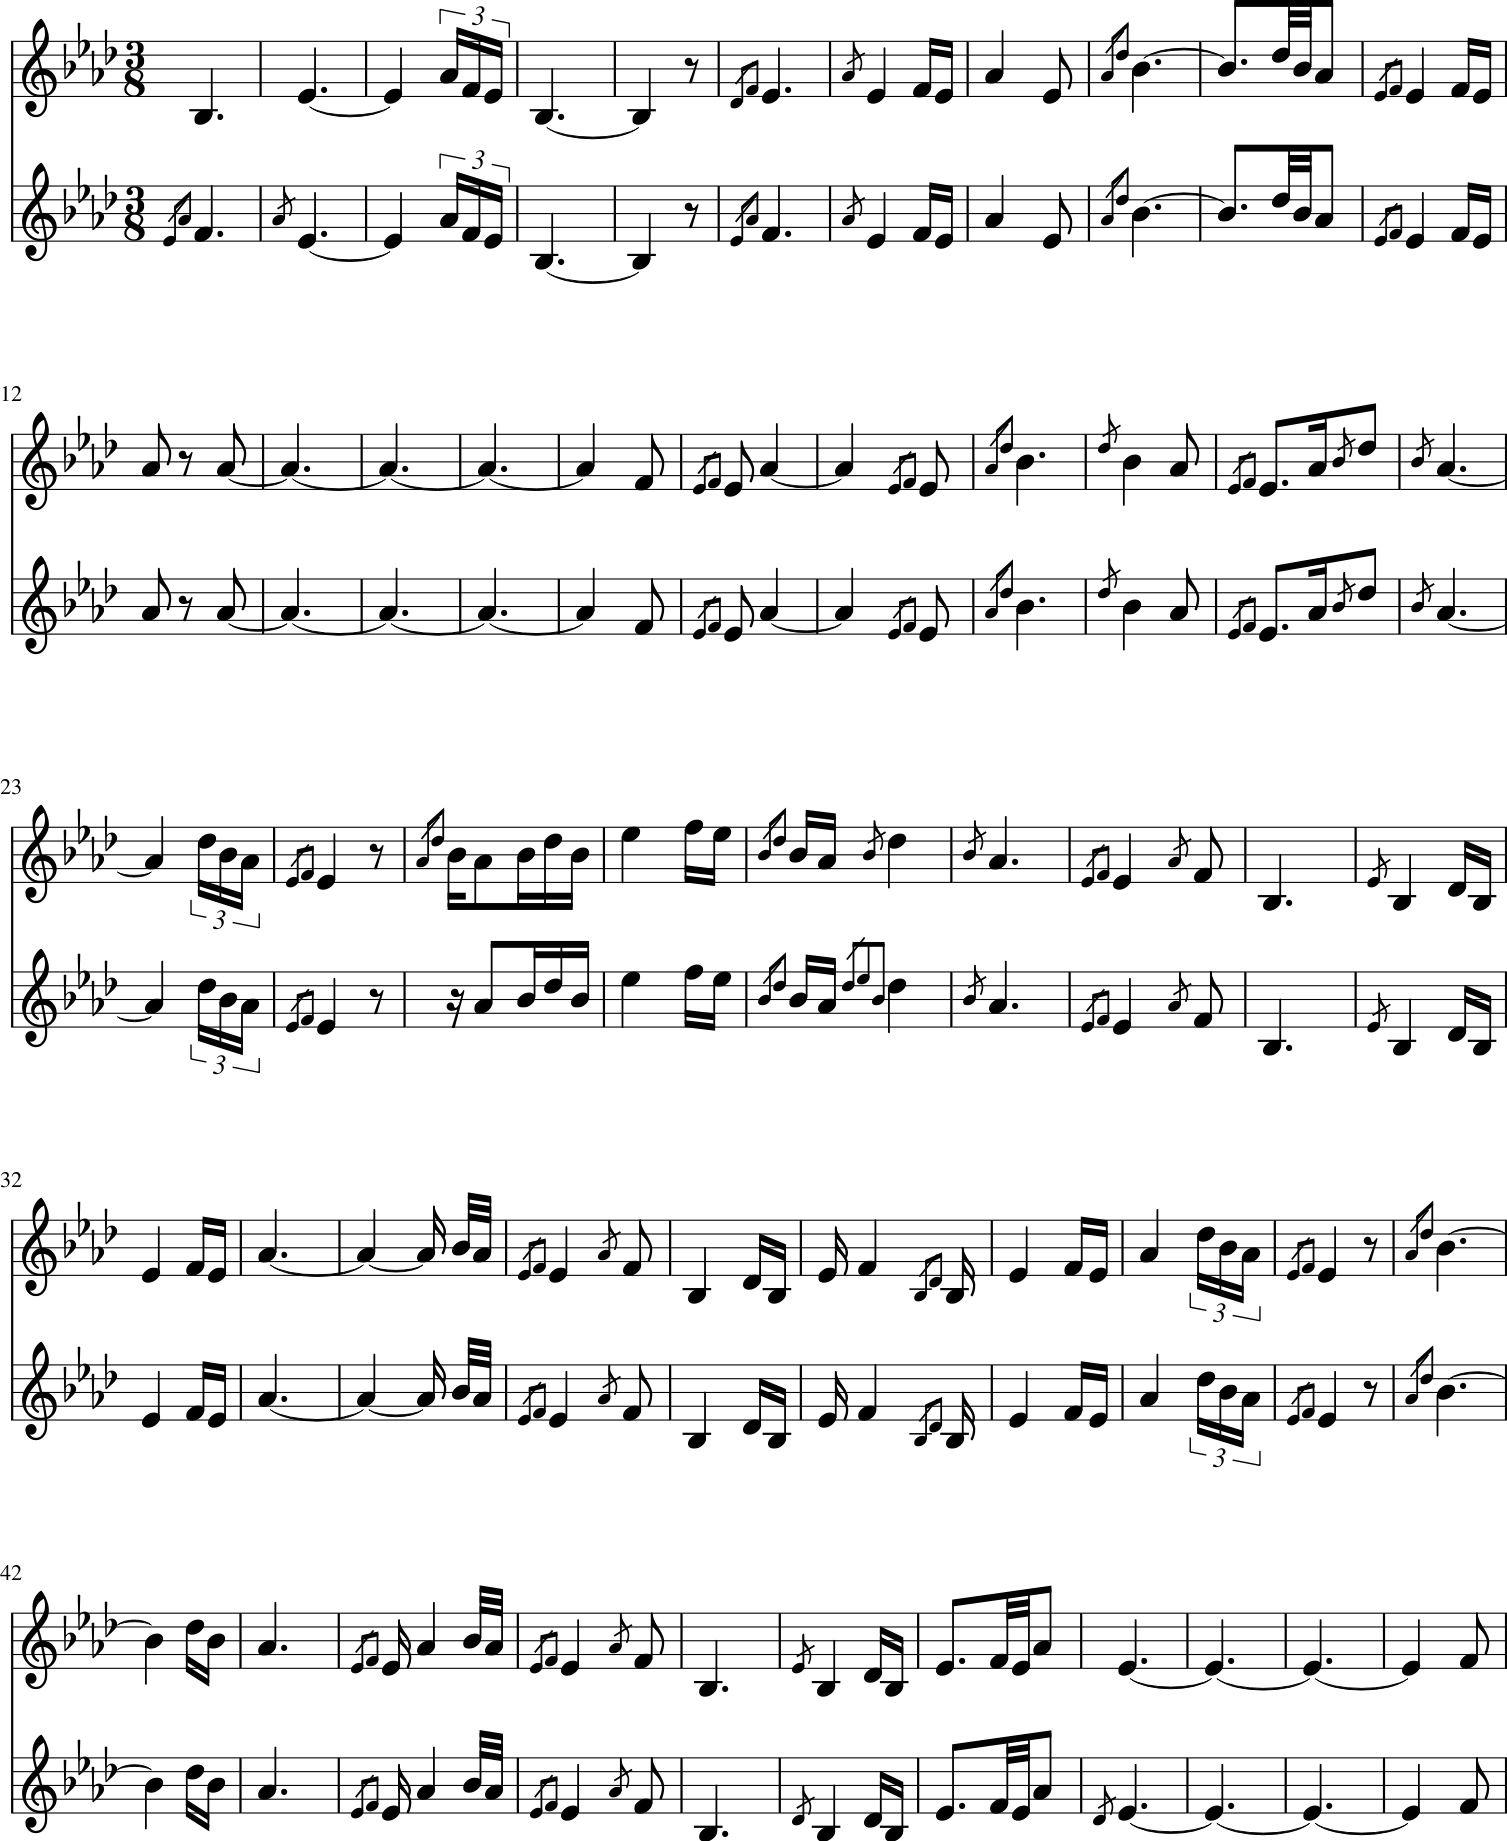

In [158]:
import music21
total_score = music21.stream.Score()

total_score.insert(0, score)
total_score.insert(0, org_score)
total_score.show()

In [10]:
masked_pitch_prob.max(dim=-1).values.argsort(descending=True)

tensor([29, 45, 44, 10, 18, 31, 52, 17, 14,  4, 19, 53, 34, 26, 40,  9, 11, 38,
        12, 41, 30, 46, 42, 27, 33, 37, 49, 16, 24,  8, 50, 43, 20, 36, 23, 48,
        32, 13,  2, 39, 51,  6, 47, 15,  1,  5, 22, 21,  7,  3, 25, 35,  0, 28])

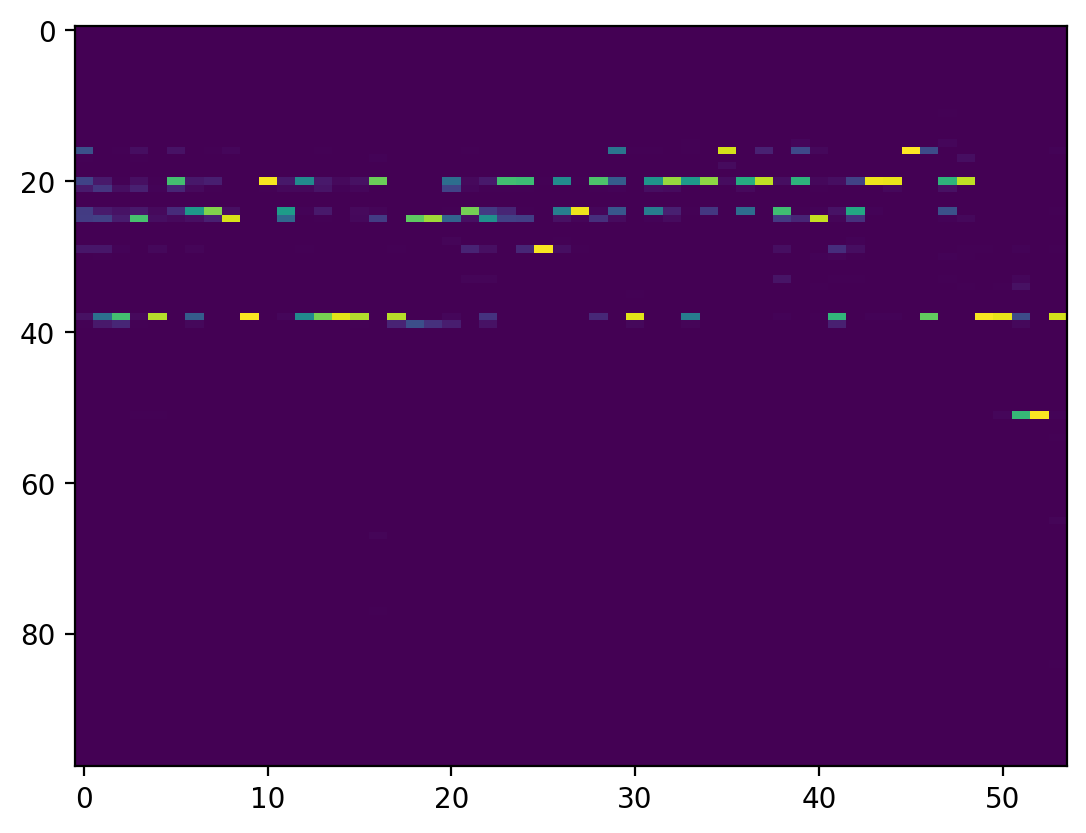

In [87]:
plt.imshow(masked_pitch_prob.detach().cpu().numpy().T, aspect='auto')

In [63]:
pred.squeeze().shape, (loss_mask==1).shape

(torch.Size([320, 2, 98]), torch.Size([320, 2]))

In [16]:
import matplotlib.pyplot as plt

In [74]:
loss_mask.shape

torch.Size([320, 2])

In [76]:
pred.squeeze()[loss_mask==1].shape

torch.Size([108, 98])

In [71]:
masked_token_prob = pred.squeeze()[loss_mask==1].softmax(dim=-1).detach()
masked_token_prob.shape

torch.Size([108, 98])

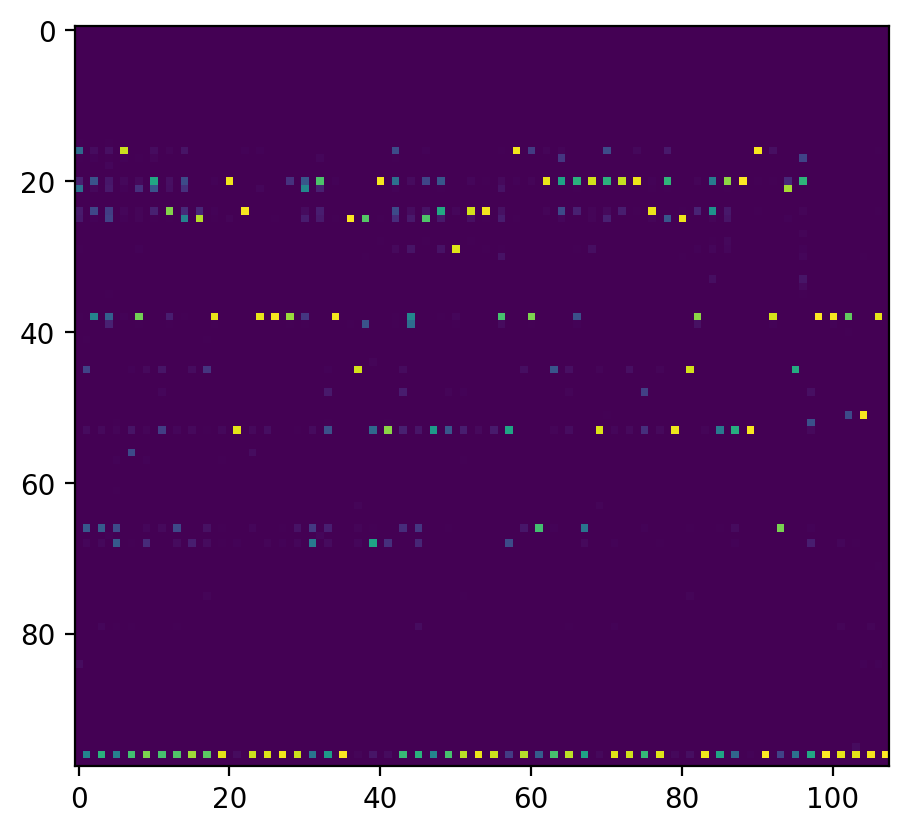

In [68]:
plt.imshow(pred.squeeze()[loss_mask==1].softmax(dim=-1).detach().T)